In [1]:
# read & manipulate data
import keras_tuner as kt
import os
import numpy as np
import pandas as pd 
import random as rn
import sys
sys.path.append("../scripts")
import tensorflow as tf
import utils

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

RANDOM_SEED = 420
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.set_visible_devices([], 'GPU') # Disable GPU since slow on my machine
tf.config.threading.set_inter_op_parallelism_threads(8)

In [2]:
pkl_path = '/Users/junxingli/Desktop/master_thesis/data/processed/SRD_Lysekil.pkl'
model_path = '/Users/junxingli/Desktop/master_thesis/models/ann_sfs/' 
feat_path = '7_features'
tuner_path = os.path.join(model_path, feat_path)
file_path = os.path.join(model_path, 'results.pkl')

overwrite = False
figs_path = '/Users/junxingli/Desktop/master_thesis/figs/ann-sfs/'
plots_path = figs_path + feat_path

In [3]:
df = pd.read_pickle(pkl_path)
df = df[df['Status'] == 'Stable']
features = df.drop(['Status', 'SRD', 'T5', 'Time'], axis=1).columns.to_list()

X = df.drop(['Status', 'SRD', 'T5'], axis=1)
y = df[['Time', 'SRD']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standard scaling the data
scaler = StandardScaler()
cols = [col for col in X_train.columns if col != 'Time']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

# Need to reshape since the scaler expects a 2D array
y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))

def update_dataframe(df, selected_features, training_error, test_error):
    """
    Update the DataFrame with a new row containing information about the selected features, training error, and test error.
    
    Parameters:
    selected_features (list): A list of selected features for this round.
    training_error (float): The training error for this round.
    test_error (float): The test error for this round.
    
    Returns:
    pandas.DataFrame: The updated DataFrame with the new row appended.
    """
    # Create a new row with 0s for all features
    features = df.columns.to_list()[:-2]
    new_row = {feature: 0 for feature in features}
    
    # Update the row based on the selected features for this round
    for feature in selected_features:
        new_row[feature] = 1
        
    # Add training and test error
    new_row['Training Error'] = training_error
    new_row['Test Error'] = test_error
    
    # Append the new row to the DataFrame
    df.loc[len(df.index)] = new_row
    return df

def get_metrics(model, scaler, X, y):
    y_pred = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred)
    
    y_inv = y.copy()
    y_inv['SRD'] = scaler.inverse_transform(y['SRD'].to_numpy().reshape(-1, 1))
    rmse = mean_squared_error(y_inv['SRD'], y_pred.flatten(), squared=False)
    r2 = r2_score(y_inv['SRD'], y_pred.flatten())
    
    return rmse, r2

def tune_ANN(df, X_features, proj_path, update=False):
    X = df[X_features]
    y = df[['SRD']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2)
    
    input_dim = X.shape[1]
    output_dim = y.shape[1]
    class MyHyperModel(kt.HyperModel):
        def build(self, hp): 
            hp_learning_rate = hp.Choice('learning_rate', 
                                        values=[1e-1, 1e-2])
                
            model = keras.Sequential()
            model.add(Input(shape=(input_dim,)))
            for i in range(hp.Int('num_layers', 0, 3)):
                model.add(Dense(units=hp.Int('units_' + str(i), 
                                            min_value=5, 
                                            max_value=60, 
                                            step=5),
                                activation='relu'))
            
            model.add(Dense(output_dim, activation='linear'))
            
            # Select optimizer    
            optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
            if optimizer == 'adam':
                model.compile(
                optimizer=keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            elif optimizer == 'SGD':
                model.compile(
                optimizer=keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            elif optimizer == 'rmsprop':
                model.compile(
                optimizer=keras.optimizers.legacy.RMSprop(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error']
                )
            
            return model

        def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                batch_size=hp.Choice("batch_size", [32, 64, 128]),
                **kwargs,
            )
    
    # Standard scaling the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
    y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))
    
    metric = 'val_mean_squared_error'
    tuner = kt.Hyperband(MyHyperModel(),
                         objective=metric,
                         max_epochs=200,
                         overwrite=False,
                         directory=tuner_path,
                         project_name=proj_path)

    stop_early = tf.keras.callbacks.EarlyStopping(monitor=metric, 
                                                patience=10)

    tuner.search(X_train, y_train, epochs=50, 
                 validation_split=0.25, callbacks=[stop_early])

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    History = best_model.fit(X_train, 
                            y_train, 
                            epochs=50, 
                            callbacks=[tf.keras.callbacks.EarlyStopping(
                                        monitor='mean_squared_error', 
                                        patience=50)
                                        ],
                            validation_split=0)
    
    rmse_train, r2_train = get_metrics(best_model, scaler, X_train, y_train)
    rmse_test, r2_test = get_metrics(best_model, scaler, X_test, y_test)
    
    # Save the model architecture and hyperparameters as txt-file
    summary_dir = os.path.join(tuner_path, proj_path, '00summary')
    os.makedirs(summary_dir, exist_ok=True)
    filename = 'model_summary.txt'
    summary_path = os.path.join(summary_dir, filename)

    with open(summary_path, 'w') as f:
        txt = f"""Training error: {rmse_train}
        R2 score: {r2_train}
        -------------------------------------
        Test error: {rmse_test}
        R2 score: {r2_test}
        -------------------------------------
        Parameters: {X_features}
        """
        f.write(str(txt))
        best_model.summary(print_fn=lambda x: f.write(x + '\n'))
        
        if hasattr(best_hps, 'values'):
            for param, value in best_hps.values.items():
                f.write(f"{param}: {value}\n")
        else:
            f.write(str(best_hps))
            
    # Save the model feautures and errors to a DataFrame
    if update:
        if not os.path.exists(file_path):
            features = df.drop(['Status', 'SRD', 'T5', 'Time'], axis=1).columns.to_list()
            sfs_df = pd.DataFrame(columns=features + ['Training Error', 'Test Error'])
            sfs_df.to_pickle(file_path)
        
        sfs_df = pd.read_pickle(file_path)    
        sfs_df = update_dataframe(sfs_df, X_features, rmse_train, rmse_test)
        sfs_df.to_pickle(file_path)
    return best_model

In [5]:
def search_features(df, optimal_features, features, proj_path, update=False):
    for i, feature in enumerate(features, start=1):
        # Skip features that are already identified as optimal
        if feature in optimal_features:
            continue

        proj_path = f'var{i}'
        tune_ANN(df, optimal_features + [feature], proj_path, update=True)

optimal_features = ['T2', 'D8', 'B12', 'T3', 'T10', 'D1', 'F1']
search_features(df, optimal_features, features, 'sfs', update=True)

Trial 254 Complete [00h 00m 02s]
val_mean_squared_error: 0.25698038935661316

Best val_mean_squared_error So Far: 0.11781042069196701
Total elapsed time: 00h 05m 14s
Epoch 1/50
299/299 [==============================] - 0s 411us/step - loss: 0.2675 - mean_squared_error: 0.2675
Epoch 2/50
299/299 [==============================] - 0s 386us/step - loss: 0.2671 - mean_squared_error: 0.2671
Epoch 3/50
299/299 [==============================] - 0s 398us/step - loss: 0.2516 - mean_squared_error: 0.2516
Epoch 4/50
299/299 [==============================] - 0s 421us/step - loss: 0.2475 - mean_squared_error: 0.2475
Epoch 5/50
299/299 [==============================] - 0s 423us/step - loss: 0.2476 - mean_squared_error: 0.2476
Epoch 6/50
299/299 [==============================] - 0s 444us/step - loss: 0.2420 - mean_squared_error: 0.2420
Epoch 7/50
299/299 [==============================] - 0s 442us/step - loss: 0.2393 - mean_squared_error: 0.2393
Epoch 8/50
299/299 [==============================

In [14]:
def find_optimal_features(df, num_features, method='train'):
    """
    Identifies columns with a value of 1 in the row with the minimum training or test error,
    after filtering rows based on the sum of their feature values being equal to num_features.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - num_features (int): The number of features that must sum to 1 to consider a row.
    - method (str): The error type to minimize ('train' or 'test').
    
    Returns:
    - list: A list of optimal feature column names.
    """

    df_filtered = df.drop(['Training Error', 'Test Error'], axis=1)
    df_filtered['Sum'] = df_filtered.sum(axis=1)
    df_features = df_filtered[df_filtered['Sum'] == num_features]
    
    # Check if there are any rows meeting the criteria
    if df_features.empty:
        raise ValueError("No rows with the specified number of features found.")
    
    # Find indexes of rows with minimum error within the filtered DataFrame
    idx_train = df_features.join(df['Training Error'])['Training Error'].idxmin()
    idx_test = df_features.join(df['Test Error'])['Test Error'].idxmin()
    if idx_train != idx_test:
        warnings.warn("Best training and best test are not the same!")
    
    # Select the row based on the specified method
    if method == 'train':
        optimal_row = df.loc[idx_train]
    elif method == 'test':
        optimal_row = df.loc[idx_test]
    else:
        raise ValueError("Method must be either 'train' or 'test'")
    
    print(f"Optimal row: {optimal_row}")
    
    # Identify columns with a value of 1 in the optimal row
    optimal_features = optimal_row.index[optimal_row.eq(1)].tolist()
    
    return optimal_features

sfs_df = pd.read_pickle(file_path)
print(find_optimal_features(sfs_df, 8, 'train'))
print(find_optimal_features(sfs_df, 8, 'test'))


Optimal row: F1                1.000000
D1                1.000000
T1                0.000000
P2                0.000000
T2                1.000000
T3                1.000000
T4                1.000000
P6                0.000000
T7                0.000000
L7                0.000000
F8                0.000000
D8                1.000000
T9                0.000000
T10               1.000000
A11               0.000000
B11               0.000000
A12               0.000000
B12               1.000000
Cap               0.000000
Training Error    0.053109
Test Error        0.040678
Name: 136, dtype: float64
['F1', 'D1', 'T2', 'T3', 'T4', 'D8', 'T10', 'B12']
Optimal row: F1                1.000000
D1                1.000000
T1                0.000000
P2                0.000000
T2                1.000000
T3                1.000000
T4                0.000000
P6                0.000000
T7                0.000000
L7                0.000000
F8                0.000000
D8                1.000000
T9    

/var/folders/p2/j2dh2mts4mz6_nskglkx1g9m0000gn/T/ipykernel_59999/2800043281.py:27: UserWarning: Best training and best test are not the same!
  warnings.warn("Best training and best test are not the same!")
/var/folders/p2/j2dh2mts4mz6_nskglkx1g9m0000gn/T/ipykernel_59999/2800043281.py:27: UserWarning: Best training and best test are not the same!
  warnings.warn("Best training and best test are not the same!")


Reloading Tuner from /Users/junxingli/Desktop/master_thesis/models/ann_sfs/7_features/var1/tuner0.json
Epoch 1/50


2024-05-02 13:03:31.981589: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


299/299 [==============================] - 0s 479us/step - loss: 0.2593 - mean_squared_error: 0.2593
Epoch 2/50
299/299 [==============================] - 0s 485us/step - loss: 0.2446 - mean_squared_error: 0.2446
Epoch 3/50
299/299 [==============================] - 0s 479us/step - loss: 0.2335 - mean_squared_error: 0.2335
Epoch 4/50
299/299 [==============================] - 0s 483us/step - loss: 0.2474 - mean_squared_error: 0.2474
Epoch 5/50
299/299 [==============================] - 0s 456us/step - loss: 0.2370 - mean_squared_error: 0.2370
Epoch 6/50
299/299 [==============================] - 0s 464us/step - loss: 0.2293 - mean_squared_error: 0.2293
Epoch 7/50
299/299 [==============================] - 0s 458us/step - loss: 0.2284 - mean_squared_error: 0.2284
Epoch 8/50
299/299 [==============================] - 0s 476us/step - loss: 0.2338 - mean_squared_error: 0.2338
Epoch 9/50
299/299 [==============================] - 0s 463us/step - loss: 0.2268 - mean_squared_error: 0.2268
Epo

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File ANN7_parity_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann-sfs/7_features/ANN7_parity_plot.pdf.


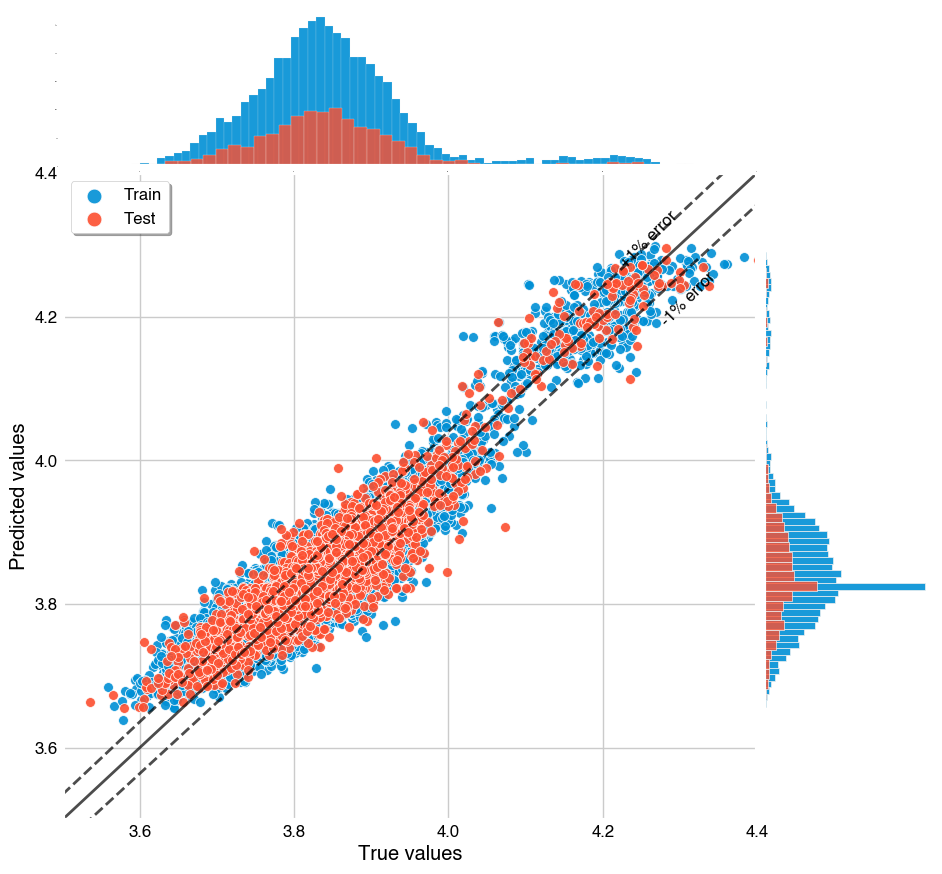

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


File ANN7_residuals_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann-sfs/7_features/ANN7_residuals_plot.pdf.


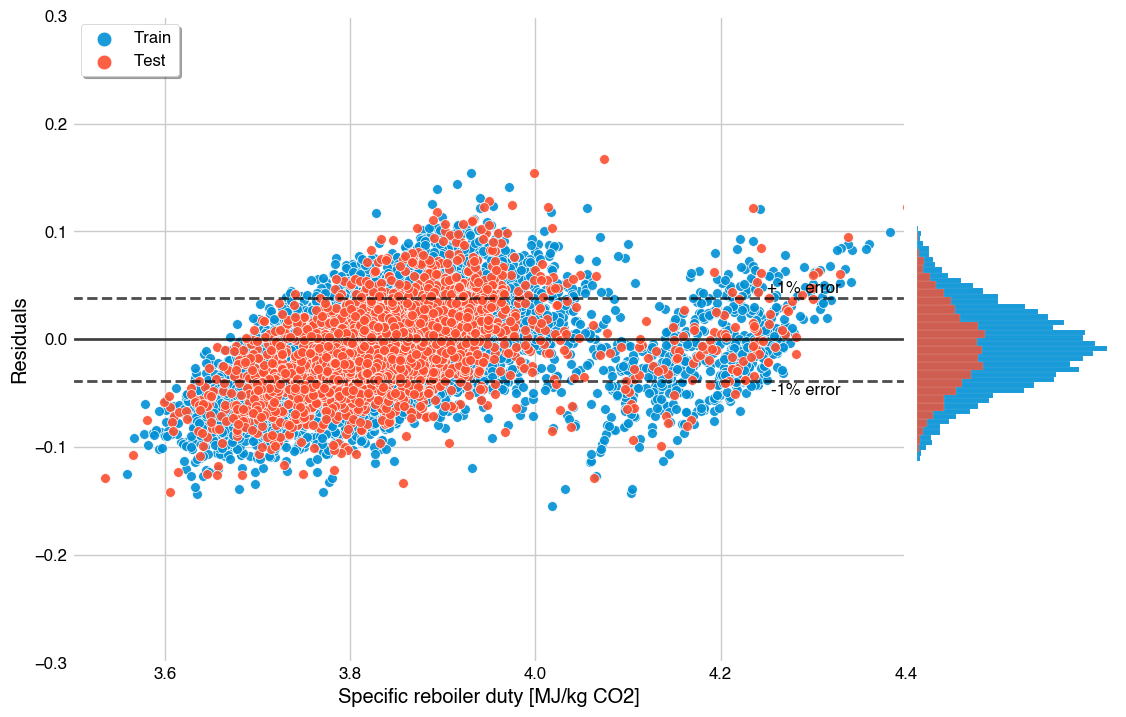

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File ANN7_KDE_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/ann-sfs/7_features/ANN7_KDE_plot.pdf.


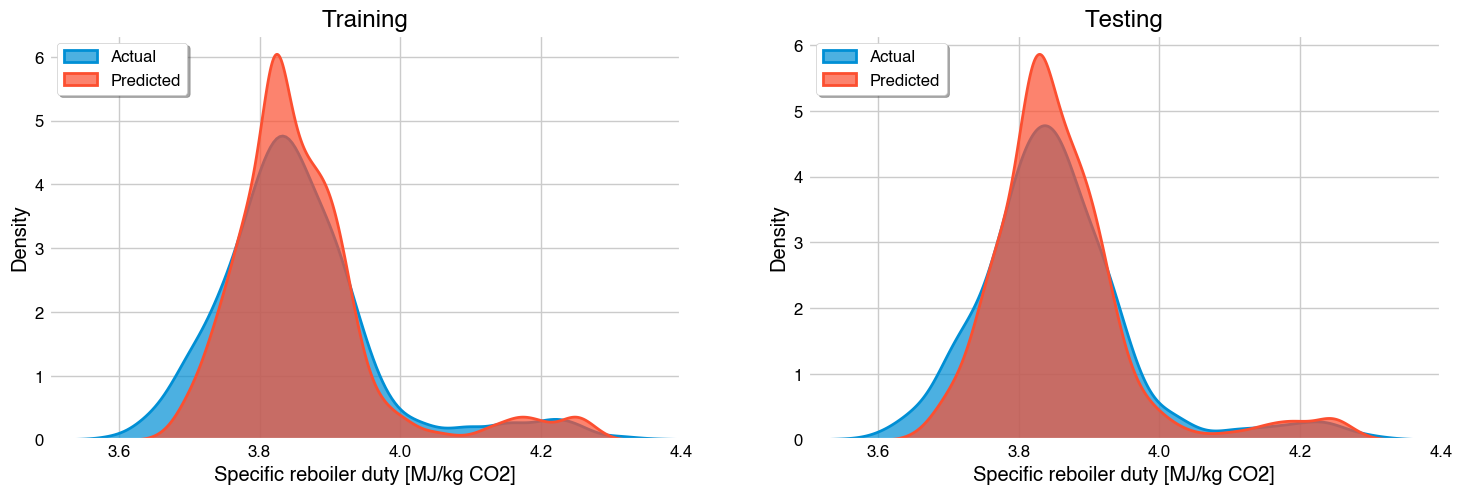

In [4]:
optimal_features = ['T2', 'D8', 'B12', 'T3', 'T10', 'D1']
new_feature = ['F1']
for i, feature in enumerate(features, start=1):
    # Skip features that are already identified as optimal
    if feature in optimal_features:
        continue

    proj_path = f'var{i}'
    if feature == new_feature[0]:
        model = tune_ANN(df, optimal_features + [feature], proj_path)

df_train, rmse_train, r2_train = utils.generate_prediction_df(model, scaler, X_train[optimal_features+new_feature+['Time']],y_train)
df_test, rmse_test, r2_test = utils.generate_prediction_df(model, scaler, X_test[optimal_features+new_feature+['Time']],y_test)

utils.make_evaluation_plots(df_train,
                            df_test,
                            "ANN7",
                            plots_path, 
                            overwrite=True, 
                            limit=[3.5, 4.4], 
                            error_line=0.01, 
                            res_limit=[-0.3, 0.3], 
                            mean=df['SRD'].mean())